In [1]:
import pathlib
import yaml
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kstest

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

First we set up some global plotting parameters

In [2]:
with open("plot_settings.yml", "r") as file:
    config = yaml.safe_load(file)

for key, value in config["paper"]["rcParams"].items():
    plt.rcParams[key] = value

legend_info = config["paper"]["legend_info"]
fig_dpi = config["paper"]["fig_dpi"]
palette = sns.color_palette(legend_info["sns_palette"], len(legend_info["mode_order"]))

This cell sets the directory in which we can find our data, as well as the simulation type this notebook will plot.

In [3]:
data_directory = pathlib.Path("data")
sim_type = "multitype_high_birth_fitness_1000"
fig_directory = pathlib.Path("fig") / sim_type
fig_directory.mkdir(parents=True, exist_ok=True)

Read in simulation data

In [4]:
rho = 0.5

tree_metrics_full_df = pd.read_csv(
    data_directory
    / f"{sim_type}"
    / "full"
    / f"tree_metrics_{sim_type}_rho{int(10*rho)}_v1_df.csv"
)
clade_metrics_full_df = pd.read_csv(
    data_directory
    / f"{sim_type}"
    / "full"
    / f"clade_metrics_{sim_type}_rho{int(10*rho)}_v1_df.csv"
)
tree_metrics_FE_df = pd.read_csv(
    data_directory
    / f"{sim_type}"
    / "FE"
    / f"tree_metrics_{sim_type}_rho{int(10*rho)}_v1_df.csv"
)
clade_metrics_FE_df = pd.read_csv(
    data_directory
    / f"{sim_type}"
    / "FE"
    / f"clade_metrics_{sim_type}_rho{int(10*rho)}_v1_df.csv"
)

tree_metrics_full_df = tree_metrics_full_df[
    tree_metrics_full_df["pruned tree size"] > 0
]
tree_metrics_full_df["mode"] = "full"
tree_metrics_FE_df["mode"] = "FE"

clade_metrics_full_df["mode"] = "full"
clade_metrics_FE_df["mode"] = "FE"

tree_metrics_df = pd.concat([tree_metrics_full_df, tree_metrics_FE_df])
clade_metrics_df = pd.concat([clade_metrics_full_df, clade_metrics_FE_df])

In [5]:
# subplot_info = "pruned tree size"
# q99 = tree_metrics_df[subplot_info].quantile(.99)
# bins = np.linspace(0, q99, 20)
# histogram_plot = sns.histplot(tree_metrics_df[[subplot_info,'mode']],
#                             x=subplot_info,
#                             bins=bins,
#                             kde=False,
#                             hue='mode',
#                             multiple="dodge",
#                             palette=palette,
#                             hue_order=legend_info['mode_order'],
#                             # ax=ax,
#                             legend=True)
# # Calculate p-values using Mann-Whitney U and Kolmogorov-Smirnov tests
# u_statistic, mann_p_value = mannwhitneyu(tree_metrics_full_df[subplot_info], tree_metrics_FE_df[subplot_info], alternative='two-sided')
# ks_statistic, ks_p_value = kstest(tree_metrics_full_df[subplot_info], tree_metrics_FE_df[subplot_info])
# plt.savefig(fig_directory/f"temp.pdf", bbox_inches='tight')
# print(mann_p_value)
# print(ks_p_value)

Next we set plot titles and the order in which they will appear

In [6]:
phenotype_name = {1: "Unfit", 2: "Fit"}


def num_lineages_extractor(s):
    match = re.match(r"num_lineages_phenotype=(\d+)_t=(\d+\.\d+)", s)
    if match:
        return float(match.group(2)), int(match.group(1))
    return None  # Default value in case of no match


def sub_tree_count_with_size_extractor(s):
    match = re.match(r"subtree_count_w_size=(\d+)", s)
    if match:
        return int(match.group(1))
    return None  # Default value in case of no match


def branch_length_extractor(s):
    match = re.match(r"branch_length_phenotype=(\d+)", s)
    if match:
        return int(match.group(1))
    return None  # Default value in case of no match


plot_titles = {
    "pruned tree size": "Event count",
    "pruned tree leaf count": "Leaf count (total)",
    "total_branch_length": "Branch length (total)",
    ("number of nodes", 1): "Events per clade (Unfit)",
    ("number of nodes", 2): "Events per clade (Fit)",
    ("branch length", 1): "Branch length per clade (Unfit)",
    ("branch length", 2): "Branch length per clade (Fit)",
}
for string in tree_metrics_df.columns:
    info = num_lineages_extractor(string)
    if info is not None:
        plot_titles[string] = f"Lineage count ({phenotype_name[info[1]]}, t={info[0]})"

    info = sub_tree_count_with_size_extractor(string)
    if info is not None:
        plot_titles[string] = f"Subtree count (size={info})"

    info = branch_length_extractor(string)
    if info is not None:
        plot_titles[string] = f"Branch length ({phenotype_name[info]})"

# Uncomment to make all plots, as will appear in the appendices
subplot_order = (
    ["pruned tree size", "pruned tree leaf count", "total_branch_length"]
    + sorted(
        [
            col
            for col in tree_metrics_df.columns
            if branch_length_extractor(col) is not None
        ],
        key=lambda x: branch_length_extractor(x),
    )
    + sorted(
        [
            col
            for col in tree_metrics_df.columns
            if sub_tree_count_with_size_extractor(col) is not None
        ],
        key=lambda x: sub_tree_count_with_size_extractor(x),
    )
    + sorted(
        [
            col
            for col in tree_metrics_df.columns
            if num_lineages_extractor(col) is not None
        ],
        key=lambda x: num_lineages_extractor(x),
    )
    + [
        ("number of nodes", 1),
        ("number of nodes", 2),
        ("branch length", 1),
        ("branch length", 2),
    ]
)

# Uncomment to make the plots, as will appear in the main text
subplot_order = (
    ["pruned tree size", "pruned tree leaf count", "total_branch_length"]
    + sorted(
        [
            col
            for col in tree_metrics_df.columns
            if branch_length_extractor(col) is not None
        ],
        key=lambda x: branch_length_extractor(x),
    )
    + sorted(
        [
            col
            for col in tree_metrics_df.columns
            if sub_tree_count_with_size_extractor(col) is not None
        ],
        key=lambda x: sub_tree_count_with_size_extractor(x),
    )
    + sorted(
        [
            col
            for col in tree_metrics_df.columns
            if num_lineages_extractor(col) is not None
        ],
        key=lambda x: num_lineages_extractor(x),
    )
    + [
        ("number of nodes", 1),
        ("number of nodes", 2),
        ("branch length", 1),
        ("branch length", 2),
    ]
)

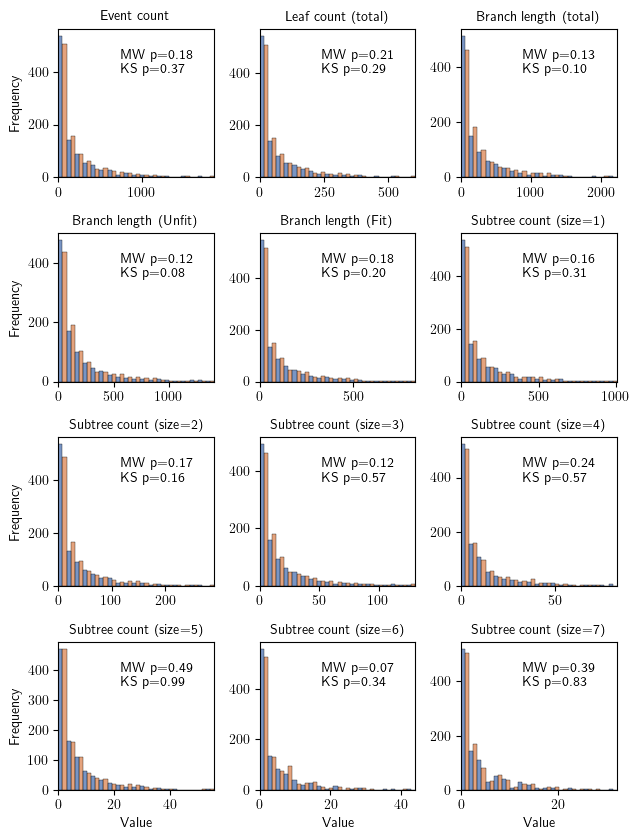

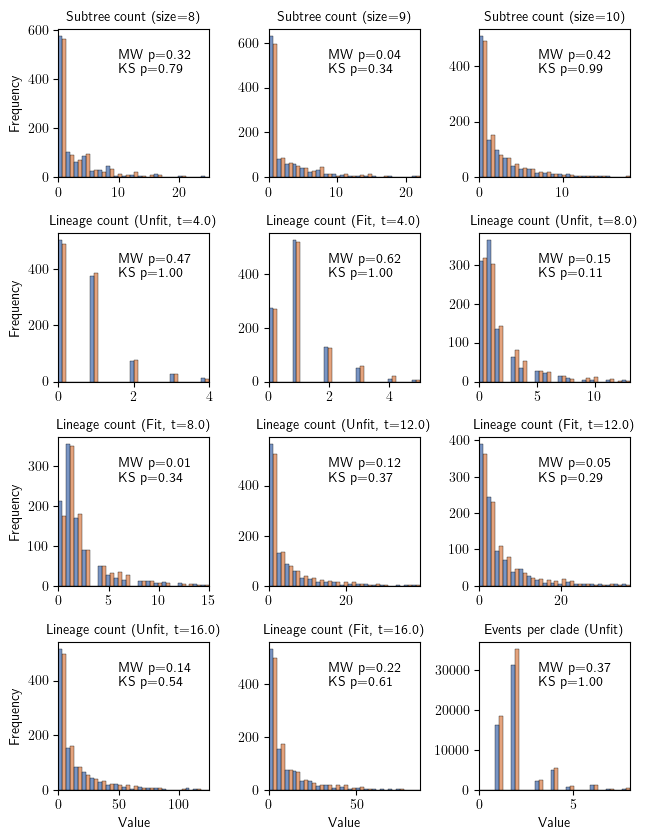

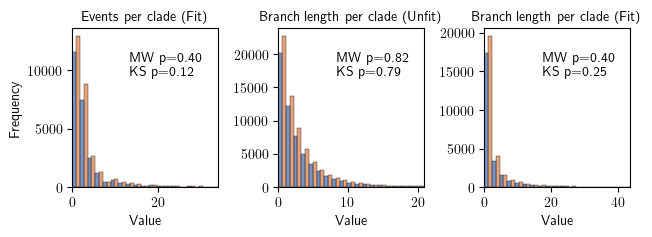

In [7]:
# %%capture


def chunker(seq, size):
    """Yield successive chunks from seq."""
    for pos in range(0, len(seq), size):
        yield seq[pos : pos + size]


# Get the number of rows and columns for subplots
n_rows, n_cols = 4, 3
plots_per_fig = n_rows * n_cols

for chunk_idx, fig_subplots in enumerate(chunker(subplot_order, plots_per_fig)):
    # Create a figure with subplots
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(6.5, 8.5)
    )  # Fills an 8.5x11 page with 1" margins and .5" for legend at bottom

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(fig_subplots):  # We make a plot
            subplot_info = fig_subplots[i]

            if subplot_info in tree_metrics_df.columns:
                # Plot histograms for the two DataFrames
                q99 = tree_metrics_df[subplot_info].quantile(0.99)
                bins = np.linspace(0, q99, 20)
                histogram_plot = sns.histplot(
                    tree_metrics_df[[subplot_info, "mode"]],
                    x=subplot_info,
                    bins=bins,
                    kde=False,
                    hue="mode",
                    multiple="dodge",
                    palette=palette,
                    hue_order=legend_info["mode_order"],
                    ax=ax,
                    legend=True,
                )
                # Calculate p-values using Mann-Whitney U and Kolmogorov-Smirnov tests
                u_statistic, mann_p_value = mannwhitneyu(
                    tree_metrics_full_df[subplot_info],
                    tree_metrics_FE_df[subplot_info],
                    alternative="two-sided",
                )
                ks_statistic, ks_p_value = kstest(
                    tree_metrics_full_df[subplot_info], tree_metrics_FE_df[subplot_info]
                )

            else:
                metric, phenotype = subplot_info
                clade_metrics_subset_df = clade_metrics_df[
                    (clade_metrics_df["metric"] == metric)
                    & (clade_metrics_df["phenotype"] == phenotype)
                ]
                q99 = clade_metrics_subset_df["value"].quantile(0.99)
                bins = np.linspace(0, q99, 20)
                histogram_plot = sns.histplot(
                    clade_metrics_subset_df[["value", "mode"]],
                    x="value",
                    bins=bins,
                    kde=False,
                    hue="mode",
                    multiple="dodge",
                    palette=palette,
                    hue_order=legend_info["mode_order"],
                    ax=ax,
                    legend=True,
                )
                # Calculate p-values using Mann-Whitney U and Kolmogorov-Smirnov tests
                is_full = clade_metrics_subset_df["mode"] == "full"
                is_FE = clade_metrics_subset_df["mode"] == "FE"
                u_statistic, mann_p_value = mannwhitneyu(
                    clade_metrics_subset_df.loc[is_full, "value"],
                    clade_metrics_subset_df.loc[is_FE, "value"],
                    alternative="two-sided",
                )
                ks_statistic, ks_p_value = kstest(
                    clade_metrics_subset_df.loc[is_full, "value"],
                    clade_metrics_subset_df.loc[is_FE, "value"],
                )

            handles = ax.get_legend().legend_handles
            labels = [text.get_text() for text in ax.get_legend().get_texts()]
            ax.get_legend().remove()  # Remove the legend from the current plot, but keep the plot itself

            ax.set_xlim(0, q99)

            # Add title with column name
            ax.set_title(plot_titles[subplot_info])

            # Display p-values as text in the subplot
            p_value_text = f"MW p={mann_p_value:.2f}\nKS p={ks_p_value:.2f}"
            ax.text(0.4, 0.7, p_value_text, fontsize=10, transform=ax.transAxes)

        ax.set_xlabel(
            "Value" if i >= len(fig_subplots) - n_cols else None
        )  # Include an x-axis label on the bottom-most plots
        ax.set_ylabel(
            "Frequency" if i % n_cols == 0 else None
        )  # Include a y-axis label on the left-most plots

        # Remove the empty subplots
        if i >= len(fig_subplots):  # this is not plotted, so we remove the axes.
            fig.delaxes(ax)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.savefig(
        fig_directory / f"distribution_tests_{chunk_idx}.pdf", bbox_inches="tight"
    )

# Change labels to desired labels
labels = [legend_info["legend_labels"][label] for label in labels]
# Create a new figure just for the legend
legend_fig, legend_ax = plt.subplots(figsize=(3, 0.5))  # Create a new subplot
# Add the legend to the subplot
legend_ax.legend(handles, labels, loc="center", ncol=len(labels))
legend_ax.axis("off")  # Turn off the axis

# Draw the legend figure canvas before saving or showing
legend_fig.canvas.draw()
plt.tight_layout()

# Save the legend to a file
plt.savefig(fig_directory / "legend.pdf", bbox_inches="tight")

# Close the figure after saving to free up memory
plt.close(legend_fig)

In [8]:
# Uncomment to make the plots, as will appear in the main text
main_text_plots = [
    "num_lineages_phenotype=1_t=16.0",
    "num_lineages_phenotype=2_t=16.0",
    ("branch length", 1),
    ("branch length", 2),
]

In [9]:
%%capture

for plot_info in main_text_plots:
    
    plt.figure(figsize=(3, 3), dpi = fig_dpi)

    if plot_info in tree_metrics_df.columns: 

        # Plot histograms for the two DataFrames
        q99 = tree_metrics_df[plot_info].quantile(.99)
        bins = np.linspace(0, q99, 20)
        histogram_ax = sns.histplot(tree_metrics_df[[plot_info,'mode']], 
                                    x=plot_info,
                                    bins=bins, 
                                    kde=False,
                                    hue='mode',
                                    multiple="dodge",
                                    palette=palette,
                                    hue_order=legend_info['mode_order'],
                                    legend=True)
        # Calculate p-values using Mann-Whitney U and Kolmogorov-Smirnov tests
        u_statistic, mann_p_value = mannwhitneyu(tree_metrics_full_df[plot_info], tree_metrics_FE_df[plot_info], alternative='two-sided')
        ks_statistic, ks_p_value = kstest(tree_metrics_full_df[plot_info], tree_metrics_FE_df[plot_info])

    else:
        metric, phenotype = plot_info
        clade_metrics_subset_df = clade_metrics_df[(clade_metrics_df['metric'] == metric) & (clade_metrics_df['phenotype'] == phenotype)]
        q99 = clade_metrics_subset_df['value'].quantile(.99)
        bins = np.linspace(0, q99, 20)
        histogram_ax = sns.histplot(clade_metrics_subset_df[['value','mode']], 
                                    x='value',
                                    bins=bins, 
                                    kde=False,
                                    hue='mode',
                                    multiple="dodge",
                                    palette=palette,
                                    hue_order=legend_info['mode_order'],
                                    legend=True)
        # Calculate p-values using Mann-Whitney U and Kolmogorov-Smirnov tests
        is_full = clade_metrics_subset_df['mode'] == 'full'
        is_FE = clade_metrics_subset_df['mode'] == 'FE'
        u_statistic, mann_p_value = mannwhitneyu(clade_metrics_subset_df.loc[is_full,'value'], clade_metrics_subset_df.loc[is_FE,'value'], alternative='two-sided')
        ks_statistic, ks_p_value = kstest(clade_metrics_subset_df.loc[is_full,'value'], clade_metrics_subset_df.loc[is_FE,'value'])               

    # Set scientific notation for y-axis
    histogram_ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    histogram_ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    handles = histogram_ax.get_legend().legend_handles
    labels = [text.get_text() for text in histogram_ax.get_legend().get_texts()]
    histogram_ax.get_legend().remove()  # Remove the legend from the current plot, but keep the plot itself

    histogram_ax.set_xlim(0,q99)

    # Add title with column name
    histogram_ax.set_title(plot_titles[plot_info])

    # Display p-values as text in the subplot
    p_value_text = f'MW p={mann_p_value:.2f}\nKS p={ks_p_value:.2f}'
    histogram_ax.text(0.4, 0.7, p_value_text, fontsize = 10, transform=histogram_ax.transAxes)

    histogram_ax.set_xlabel('Value')
    histogram_ax.set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout();

    # Show the plot
    # plt.show()
    plt.savefig(fig_directory/f'{plot_titles[plot_info].replace(" ","-").replace("(","").replace(")","").replace(",","").replace("=","").replace(".","_")}.pdf', bbox_inches='tight')

# Change labels to desired labels
labels = [legend_info['legend_labels'][label] for label in labels]
# Create a new figure just for the legend
legend_fig, legend_ax = plt.subplots(figsize=(3, .5), dpi = fig_dpi)  # Create a new subplot
# Add the legend to the subplot
legend_ax.legend(handles, labels, loc='center', ncol = len(labels))
legend_ax.axis('off')  # Turn off the axis

# Draw the legend figure canvas before saving or showing
legend_fig.canvas.draw()
plt.tight_layout()

# Save the legend to a file
plt.savefig(fig_directory/'legend.pdf', bbox_inches='tight', dpi = fig_dpi)

# Close the figure after saving to free up memory
plt.close(legend_fig)